In [1]:
import os
import numpy as np
from skimage import io, transform, feature
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
############# Load dataset ##############
def load_images(folder_path):
    images = []

    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(('.ppm')):
                img_path = os.path.join(root, filename)
                img = io.imread(img_path)
                img = transform.resize(img, (64, 64), anti_aliasing=True)
                images.append(img)
    
    return np.array(images)

# Load and preprocess images using HOG features
X_train = load_images('./dataset/training/')
X_test = load_images('./dataset/testing/')

# Shuffle the training and testing datasets
np.random.shuffle(X_train)
np.random.shuffle(X_test)

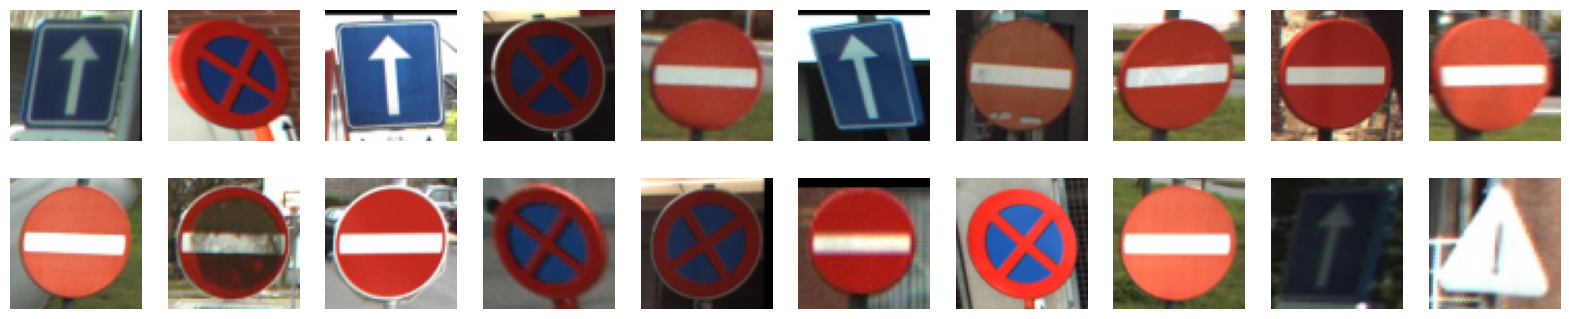

In [3]:
############# Show samples from X_train ##############
X_train_reshaped = X_train.reshape((-1, 64, 64, 3))

num_samples_to_display = 20

plt.figure(figsize=(20, 4))
for i in range(num_samples_to_display):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train_reshaped[i])
    plt.axis('off')

plt.show()

In [4]:
############# Extract HOG features ##############
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Specify channel_axis for multichannel images
        hog_img = feature.hog(img, block_norm='L2-Hys', pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
        hog_features.append(hog_img)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [5]:
############# MinMaxScaler #############
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)


In [6]:
############# PCA #############
n_components = 50

pca = PCA(n_components=n_components, random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

h:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
h:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
h:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
h:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

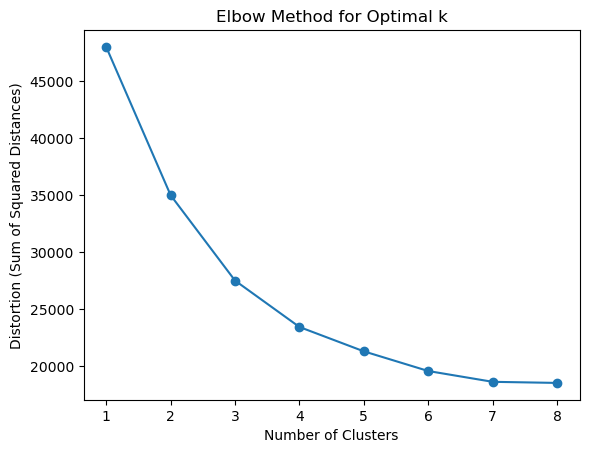

In [7]:
############# Find optimal cluster number ##############
def find_optimal_clusters(data, max_clusters=8):
    distortions = []
    
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_init=10, n_clusters=i, init='random', random_state=42, max_iter=100)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion (Sum of Squared Distances)')
    plt.show()

find_optimal_clusters(X_train_pca)

In [8]:
############ K-Means ##############
num_clusters = 5

kmeans = KMeans(n_init=10, n_clusters=num_clusters, init='k-means++', random_state=42, max_iter=300)
kmeans.fit(X_train_pca)

labels = kmeans.labels_

h:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
# # Tuning num_clusters
# for num_clusters in range(2, 11):
#     kmeans = KMeans(n_init=10, n_clusters=num_clusters, init='random', random_state=42, max_iter=100)
#     kmeans.fit(X_train_pca)
#     sil_score = silhouette_score(X_train_pca, kmeans.labels_)
#     print(f'Number of Clusters: {num_clusters}, Silhouette Score: {sil_score}')

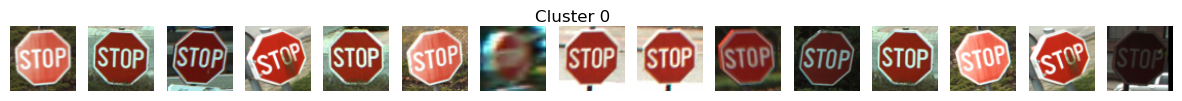

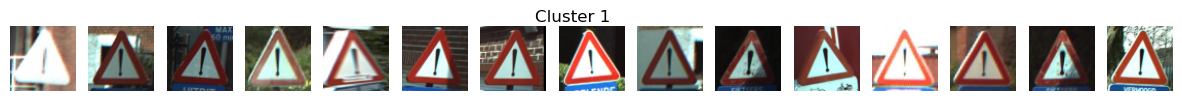

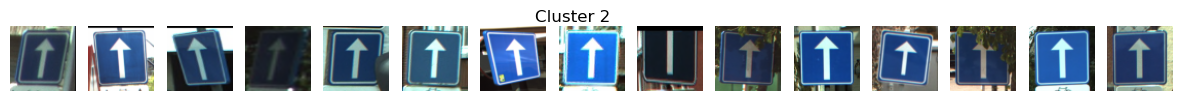

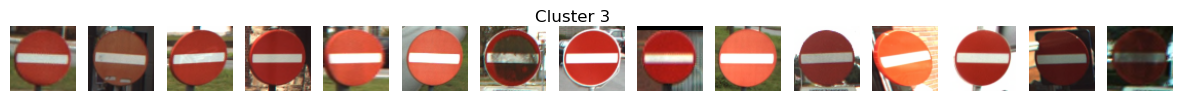

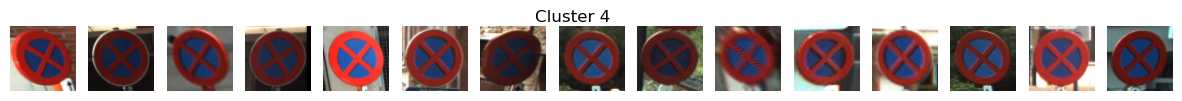

In [10]:
############# Display Samples from each cluster ##############
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    plt.figure(figsize=(15, 1))
    for j, index in enumerate(cluster_indices[:15]):
        plt.subplot(1, 15, j + 1)
        plt.imshow(X_train[index])
        plt.axis('off')
    plt.suptitle(f'Cluster {i}')
    plt.show()

In [11]:
############# Display number of images of each cluster ##############
for i in range(num_clusters):
    cluster_indices = np.where(labels == i)[0]
    numberOfImages = len(cluster_indices)
    print(f'Number of images of cluster {i} : {numberOfImages}')

Number of images of cluster 0 : 43
Number of images of cluster 1 : 87
Number of images of cluster 2 : 199
Number of images of cluster 3 : 348
Number of images of cluster 4 : 122


In [12]:
# ############## Display all images from each cluster ##############
# import math

# for i in range(num_clusters):
#     cluster_indices = np.where(labels == i)[0]
#     numberOfImages = len(cluster_indices)

#     numberOfCols = 10
#     numberOfRows = math.ceil(numberOfImages / numberOfCols)

#     plt.figure(figsize=(numberOfCols * 2, numberOfRows * 2))
#     for j, index in enumerate(cluster_indices[:numberOfImages]):
#         plt.subplot(numberOfRows, numberOfCols, j + 1)
#         plt.imshow(X_train[index])
#         plt.axis('off')
#     plt.suptitle(f'Cluster {i}')
#     plt.show()

In [13]:
print("Train score :", kmeans.score(X_train_pca))
print("Test score :", kmeans.score(X_test_pca))
print("Centers :", len(kmeans.cluster_centers_))
print("Inertia :", kmeans.inertia_)
print("=========================================")
sil_score = silhouette_score(X_train_pca, kmeans.labels_)
print("Silhouette Score :", sil_score)

Train score : -21277.109285645874
Test score : -3868.847903938886
Centers : 5
Inertia : 21277.109285645874
Silhouette Score : 0.363786678601101
